### Classification of Hyperspectral Vegetation Image veg_00108

---

In [1]:
# -- here are functions that generate a class that memory maps the raw data 
#    cube.  After executing this cell, the syntax is:
#    fname = "[path to data]/foo.raw"
#    cube = read_hyper(fname)

import os
import numpy as np

def read_header(hdrfile, verbose=True):
    """
    Read a Middleton header file.

    Parameters
    ----------
    hdrfile : str
        Name of header file.
    verbose : bool, optional
        If True, alert the user.

    Returns
    -------
    dict : dict
        A dictionary continaing the number of rows, columns, and wavelengths
        as well as an array of band centers.
    """

    # -- alert
    if verbose:
        print("reading and parsing {0}...".format(hdrfile))

    # -- open the file and read in the records
    recs = [rec for rec in open(hdrfile)]

    # -- parse for samples, lines, bands, and the start of the wavelengths
    for irec, rec in enumerate(recs):
        if 'samples' in rec:
            samples = int(rec.split("=")[1])
        elif 'lines' in rec:
            lines = int(rec.split("=")[1])
        elif 'bands' in rec:
            bands = int(rec.split("=")[1])
        elif "Wavelength" in rec:
            w0ind = irec+1

    # -- parse for the wavelengths
    waves = np.array([float(rec.split(",")[0]) for rec in 
                      recs[w0ind:w0ind+bands]])

    # -- return a dictionary
    return {"nrow":samples, "ncol":lines, "nwav":bands, "waves":waves}


def read_raw(rawfile, shape, hyper=False, verbose=True):
    """
    Read a Middleton raw file.

    Parameters
    ----------
    rawfile : str
        The name of the raw file.
    shape : tuple
        The output shape of the data cube (nwav, nrow, ncol).
    hyper : bool, optional
        Set this flag to read a hyperspectral image.
    verbose : bool, optional
        Alert the user.

    Returns
    -------
    memmap : memmap
        A numpy memmap of the datacube.
    """

    # -- alert
    if verbose:
        print("reading {0}...".format(rawfile))

    # -- read either broadband or hyperspectral image
    if hyper:
        return np.memmap(rawfile, np.uint16, mode="r") \
            .reshape(shape[2], shape[0], shape[1])[:, :, ::-1] \
            .transpose(1, 2, 0)
    else:
        return np.memmap(rawfile, np.uint8, mode="r") \
            .reshape(shape[1], shape[2], shape[0])[:, :, ::-1]


def read_hyper(fpath, fname=None, full=True):
    """
    Read a full hyperspectral scan (raw and header file).

    Parameters
    ----------
    fpath : str
        Either the full name+path of the raw file or the path of the raw file.
        If the latter, fname must be supplied.
    fname : str, optional
        The name of the raw file (required if fpath is set to a path).
    full : bool, optional
        If True, output a class containing data and supplementary information.
        If False, output only the data.

    Returns
    -------
    output or memmap : class or memmap
        If full is True, a class containing data plus supplementary 
        information.  If full is False, a memmap array of the data.
    """

    # -- set up the file names
    if fname is not None:
        fpath = os.path.join(fpath, fname)

    # -- read the header
    hdr = read_header(fpath.replace("raw", "hdr"))
    sh  = (hdr["nwav"], hdr["nrow"], hdr["ncol"])

    # -- if desired, only output data cube
    if not full:
        return read_raw(fpath, sh, hyper=True)

    # -- output full structure
    class output():
        def __init__(self, fpath):
            self.filename = fpath
            self.data     = read_raw(fpath, sh, hyper=True)
            self.waves    = hdr["waves"]
            self.nwav     = sh[0]
            self.nrow     = sh[1]
            self.ncol     = sh[2]

    return output(fpath)

In [2]:
fname = "../image_files/veg_00108.raw"
cube = read_hyper(fname)

reading and parsing ../image_files/veg_00108.hdr...
reading ../image_files/veg_00108.raw...


In [3]:
cube_sub = cube.data[:, :, :].astype(float)
print(cube_sub.shape)

(848, 1600, 1600)


In [4]:
cube_reshaped = cube_sub.transpose(1, 2, 0).reshape((cube_sub.shape[1] * cube_sub.shape[2]), cube_sub.shape[0])
print(cube_reshaped.shape)

(2560000, 848)


In [5]:
# create array of indices

num_of_bins = 20
bin_ind = []

for i in range(0, num_of_bins + 1):
    low_ind = int(i*int(cube_sub.shape[0]/num_of_bins))
    upp_ind = int(low_ind + int(cube_sub.shape[0]/num_of_bins))
    bin_ind.append([low_ind, upp_ind])
bin_ind[-1][-1] = cube_sub.shape[0]
    
print(bin_ind)

[[0, 42], [42, 84], [84, 126], [126, 168], [168, 210], [210, 252], [252, 294], [294, 336], [336, 378], [378, 420], [420, 462], [462, 504], [504, 546], [546, 588], [588, 630], [630, 672], [672, 714], [714, 756], [756, 798], [798, 840], [840, 848]]


In [6]:
cube_binned = np.zeros(shape=(cube_reshaped.shape[0], num_of_bins))

for i in range(num_of_bins):
    cube_binned[:, i] = cube_reshaped[:, bin_ind[i][0]:bin_ind[i][1]].mean(1)

print(cube_binned.shape)

(2560000, 20)


In [7]:
# function to read coordinates from file

def point_from_string(text):
    
    items = text.strip("\n").split(" ")
    rind = int(items[0])
    cind = int(items[1])
    
    return rind, cind

In [8]:
# read manually selected coordinates files

# sky coordinates
sky_file = open("./sky_coordinates.txt", "r")
sky_coords = sky_file.readlines()
sky_file.close()
sky_coords = np.array([point_from_string(line) for line in sky_coords])
print(sky_coords.shape)

# vegetation coordinates
veg_file = open("./vegetation_coordinates.txt", "r")
veg_coords = veg_file.readlines()
veg_file.close()
veg_coords = np.array([point_from_string(line) for line in veg_coords])
print(veg_coords.shape)

# built coordinates
built_file = open("./built_coordinates.txt", "r")
built_coords = built_file.readlines()
built_file.close()
built_coords = np.array([point_from_string(line) for line in built_coords])
print(built_coords.shape)

(1000, 2)
(600, 2)
(1010, 2)


In [9]:
# split manually selected pixels to 80% training and 20% testing sets
import random

# sky coordinates
sky_ind = np.arange(sky_coords.shape[0])
random.shuffle(sky_ind)
lim_ind = int(len(sky_ind)*0.8)
sky_train_ind = sky_ind[:lim_ind]
sky_test_ind = sky_ind[lim_ind:]
print("sky %d %d" % (len(sky_train_ind), len(sky_test_ind)))

# vegetation coordinates
veg_ind = np.arange(veg_coords.shape[0])
random.shuffle(veg_ind)
lim_ind = int(len(veg_ind)*0.8)
veg_train_ind = veg_ind[:lim_ind]
veg_test_ind = veg_ind[lim_ind:]
print("veg %d %d" % (len(veg_train_ind), len(veg_test_ind)))

# built coordinates
built_ind = np.arange(built_coords.shape[0])
random.shuffle(built_ind)
lim_ind = int(len(built_ind)*0.8)
built_train_ind = built_ind[:lim_ind]
built_test_ind = built_ind[lim_ind:]
print("built %d %d" % (len(built_train_ind), len(built_test_ind)))

sky 800 200
veg 480 120
built 808 202


In [10]:
cube_binned_full = cube_binned.reshape(cube_sub.shape[1], cube_sub.shape[2], num_of_bins)
cube_binned_full.shape

(1600, 1600, 20)

In [11]:
cube_sky_train = cube_binned_full[sky_coords[sky_train_ind[:], 0], sky_coords[sky_train_ind[:], 1], :]
cube_sky_test = cube_binned_full[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1], :]
print(cube_sky_train.shape, cube_sky_test.shape)

cube_veg_train = cube_binned_full[veg_coords[veg_train_ind[:], 0], veg_coords[veg_train_ind[:], 1], :]
cube_veg_test = cube_binned_full[veg_coords[veg_test_ind[:], 0], veg_coords[veg_test_ind[:], 1], :]
print(cube_veg_train.shape, cube_veg_test.shape)

cube_built_train = cube_binned_full[built_coords[built_train_ind[:], 0], built_coords[built_train_ind[:], 1], :]
cube_built_test = cube_binned_full[built_coords[built_test_ind[:], 0], built_coords[built_test_ind[:], 1], :]
print(cube_built_train.shape, cube_built_test.shape)

(800, 20) (200, 20)
(480, 20) (120, 20)
(808, 20) (202, 20)


In [12]:
# concatenate training and testing sets and create index arrays

cube_train = np.concatenate((cube_sky_train, cube_veg_train, cube_built_train), axis=0)
cube_train_labels = [0]*cube_sky_train.shape[0] + [1]*cube_veg_train.shape[0] + [2]*cube_built_train.shape[0]

cube_test = np.concatenate((cube_sky_test, cube_veg_test, cube_built_test), axis=0)
cube_test_labels = [0]*cube_sky_test.shape[0] + [1]*cube_veg_test.shape[0] + [2]*cube_built_test.shape[0]


In [13]:
# Train decision tree

from sklearn import tree

dt = tree.DecisionTreeClassifier()
dTree = dt.fit(cube_train, cube_train_labels)

In [14]:
# test model with test set

testModel = dTree.predict(cube_test)

comparison = np.equal(testModel, cube_test_labels)
correct = np.where(comparison == True)
accuracy = len(correct[0]) * 100 / len(comparison)
print(accuracy)

99.04214559386973


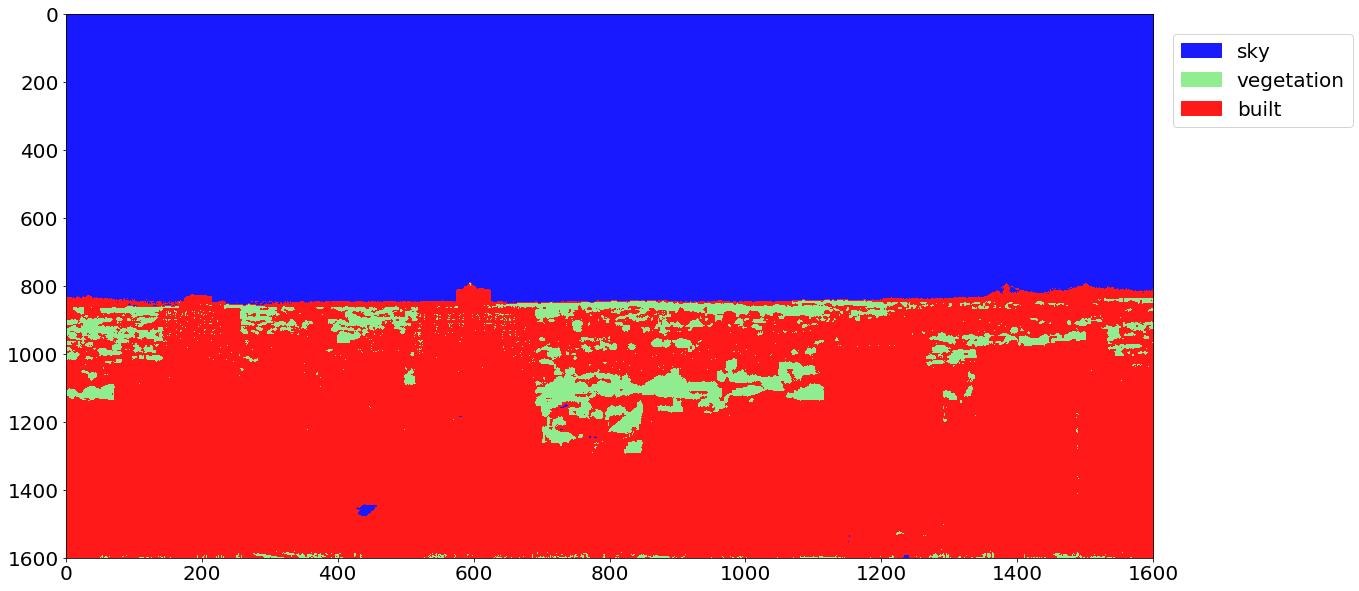

In [16]:
# classify entire binned cube

predictCube = dTree.predict(cube_binned)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
%matplotlib inline

predictCube_reshape = predictCube.reshape(cube_sub.shape[1], cube_sub.shape[2])

t=1
cmap = {0:[0.1,0.1,1.0,t], 1:[0.564,0.933,0.564,t], 2:[1.0,0.1,0.1,t]}
labels = {0:'sky', 1:"vegetation", 2:"built"}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]
fig, ax = plt.subplots(figsize = (20, 10))
ax.tick_params(labelsize=20)
plt.imshow(arrayShow, aspect=0.5)
plt.legend(handles=patches, bbox_to_anchor=(1,1), loc=2, borderaxespad=1.0, prop={'size':20})
plt.show()